In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from pandas import Series, DataFrame
from pylab import rcParams

In [3]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [4]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## data investigation and cleaning details in `LI_03_03_begin_lori.ipynb`
## one-hot encoding of categories  in `u12_3_10_knn_tuning\titanic_example.ipynb`

## read data

In [5]:
address = 'titanic-training-data.csv'
titanic_training = pd.read_csv(address)
titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

titanic_training.head()
titanic_training.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## check for missing values

In [6]:
titanic_training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## drop columns not needed for predicting

In [7]:
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


## impute missing values for `Age`

In [8]:
def age_approx(cols):
    Age = cols[0]
    Parch = cols[1]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30
        
    else:
        return Age

In [9]:
titanic_data['Age']= titanic_data[['Age', 'Parch']].apply(age_approx, axis=1)

## drop rows with missing valus for `Embarked`

In [10]:
titanic_data.dropna(inplace=True)
titanic_data.reset_index(inplace=True, drop=True)

print(titanic_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB
None


## investigate categories and encode

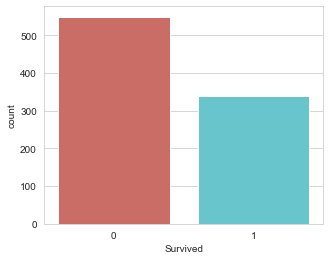

In [11]:
sb.countplot(x='Survived', data=titanic_data, palette='hls');

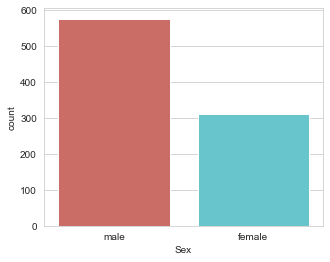

In [12]:
sb.countplot(x='Sex', data=titanic_data, palette='hls');

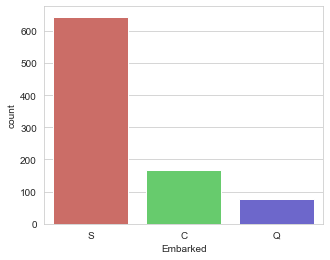

In [13]:
sb.countplot(x='Embarked', data=titanic_data, palette='hls');

In [14]:
en_sex = LabelEncoder()
en_sex.fit(titanic_data['Sex'])
titanic_data['sex_en'] = en_sex.transform(titanic_data['Sex'])

en_embarked = LabelEncoder()
en_embarked.fit(titanic_data['Embarked'])
titanic_data['embarked_en'] = en_embarked.transform(titanic_data['Embarked'])

en_sex.classes_
en_embarked.classes_
titanic_data.head()

LabelEncoder()

LabelEncoder()

array(['female', 'male'], dtype=object)

array(['C', 'Q', 'S'], dtype=object)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,sex_en,embarked_en
0,1,0,3,male,22.0,1,0,7.2500,S,1,2
1,2,1,1,female,38.0,1,0,71.2833,C,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,0,2
3,4,1,1,female,35.0,1,0,53.1000,S,0,2
4,5,0,3,male,35.0,0,0,8.0500,S,1,2


## drop correlated features

In [15]:
titanic_model = titanic_data.drop(['Pclass', 'Fare'], axis=1)
titanic_model.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Embarked,sex_en,embarked_en
0,1,0,male,22.0,1,0,S,1,2
1,2,1,female,38.0,1,0,C,0,0
2,3,1,female,26.0,0,0,S,0,2
3,4,1,female,35.0,1,0,S,0,2
4,5,0,male,35.0,0,0,S,1,2


In [16]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,sex_en,embarked_en
0,1,0,3,male,22.0,1,0,7.2500,S,1,2
1,2,1,1,female,38.0,1,0,71.2833,C,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,0,2
3,4,1,1,female,35.0,1,0,53.1000,S,0,2
4,5,0,3,male,35.0,0,0,8.0500,S,1,2


## regression

In [17]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'sex_en', 'embarked_en']
target = ['Survived']

X_train, X_test, y_train, y_test = train_test_split(titanic_data[features],
                                                    titanic_data[target[0]],
                                                    test_size=0.2,
                                                    random_state=200)

In [18]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [19]:
LogReg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [20]:
LogReg.classes_
LogReg.coef_
LogReg.n_features_in_

array([0, 1], dtype=int64)

array([[-0.89579292, -0.02490612, -0.27194241, -0.06170372, -2.37717246,
        -0.07354992]])

6